<a href="https://colab.research.google.com/github/lazy-wolf/python-class-notes/blob/main/TensorFlow_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import PIL.Image as Image
import tensorflow_datasets as tfds
import pandas as pd

In [ ]:
(training_set, validation_set), dataset_info = tfds.load(
    'imagewang/160px',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='imagewang',
    full_name='imagewang/160px/2.0.0',
    description="""
    Imagewang contains Imagenette and Imagewoof combined Image网 (pronounced
    "Imagewang"; 网 means "net" in Chinese) contains Imagenette and Imagewoof
    combined, but with some twists that make it into a tricky semi-supervised
    unbalanced classification problem:
    
    *   The validation set is the same as Imagewoof (i.e. 30% of Imagewoof images);
        there are no Imagenette images in the validation set (they're all in the
        training set)
    *   Only 10% of Imagewoof images are in the training set!
    *   The remaining are in the unsup ("unsupervised") directory, and you can not
        use their labels in training!
    *   It's even hard to type and hard to say!
    
    The dataset comes in three variants:
    
    *   Full size
    *   320 px
    *   160 px
    
    This dataset consists of the Imagenette dataset {size} variant.
    """,
    config_description

In [ ]:
training_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
validation_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
dataset_info.features['label']

ClassLabel(shape=(), dtype=int64, num_classes=20)

In [ ]:
dataset_info.features['label'].num_classes

20

In [ ]:
num_classes = dataset_info.features['label'].num_classes

In [ ]:
dataset_info.features['label'].names

['n03394916',
 'n03417042',
 'n02089973',
 'n02086240',
 'n02105641',
 'n02087394',
 'n02099601',
 'n02115641',
 'n03445777',
 'n02102040',
 'n03425413',
 'n03888257',
 'n03028079',
 'n03000684',
 'n01440764',
 'n02093754',
 'n02111889',
 'n02096294',
 'n02088364',
 'n02979186']

In [ ]:
len(training_set)

10268

In [ ]:
len(validation_set)

4401

In [ ]:
training_dict={}
for i in training_set:
  if dataset_info.features['label'].names[i[1].numpy()] not in training_dict:
    training_dict[dataset_info.features['label'].names[i[1].numpy()]]=1
  else:
    training_dict[dataset_info.features['label'].names[i[1].numpy()]]+=1


In [ ]:
training_df=pd.DataFrame(training_dict.items(),columns=['Labels','Count'])

In [ ]:
training_df['Count'].sum()

10268

In [ ]:
num_training_examples = training_df['Count'].sum()

<Axes: xlabel='Labels'>

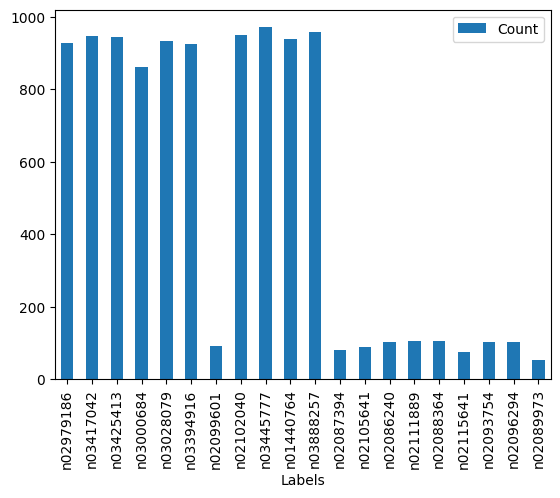

In [ ]:
training_df.plot.bar(x="Labels", y="Count", rot=90)


In [ ]:
validation_dict={}
for i in validation_set:
  if dataset_info.features['label'].names[i[1].numpy()] not in validation_dict:
    validation_dict[dataset_info.features['label'].names[i[1].numpy()]]=1
  else:
    validation_dict[dataset_info.features['label'].names[i[1].numpy()]]+=1

In [ ]:
validation_df=pd.DataFrame(validation_dict.items(),columns=['Labels','Count'])

In [ ]:
validation_df['Count'].sum()

4401

In [ ]:
num_validation_examples = validation_df['Count'].sum()

<Axes: xlabel='Labels'>

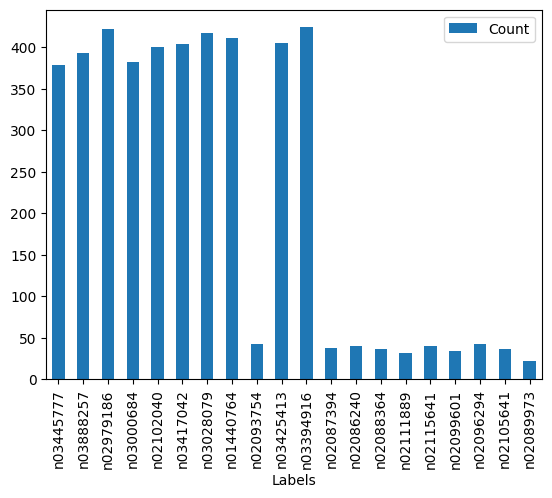

In [ ]:
validation_df.plot.bar(x="Labels", y="Count", rot=90)

In [ ]:
IMAGE_RES = 128
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label
BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
print(train_batches)
print(validation_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
URL = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [ ]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 20)                20040     
                                                                 
Total params: 1712529 (6.53 MB)
Trainable params: 20040 (78.28 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
EPOCHS = 25
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/25
321/321 [==============================] - 46s 133ms/step - loss: 0.5864 - accuracy: 0.8341 - val_loss: 0.3915 - val_accuracy: 0.8864
Epoch 2/25
321/321 [==============================] - 38s 120ms/step - loss: 0.2875 - accuracy: 0.9118 - val_loss: 0.3823 - val_accuracy: 0.8928
Epoch 3/25
321/321 [==============================] - 33s 104ms/step - loss: 0.2161 - accuracy: 0.9351 - val_loss: 0.3770 - val_accuracy: 0.8957
Epoch 4/25
321/321 [==============================] - 34s 107ms/step - loss: 0.1751 - accuracy: 0.9445 - val_loss: 0.3845 - val_accuracy: 0.8975
Epoch 5/25
321/321 [==============================] - 35s 109ms/step - loss: 0.1432 - accuracy: 0.9551 - val_loss: 0.4140 - val_accuracy: 0.8921
Epoch 6/25
321/321 [==============================] - 34s 106ms/step - loss: 0.1250 - accuracy: 0.9601 - val_loss: 0.4288 - val_accuracy: 0.8898
Epoch 7/25
321/321 [==============================] - 34s 105ms/step - loss: 0.1037 - accuracy: 0.9679 - val_loss: 0.4387 - val_ac

Text(0.5, 1.0, 'Training and Validation Loss')

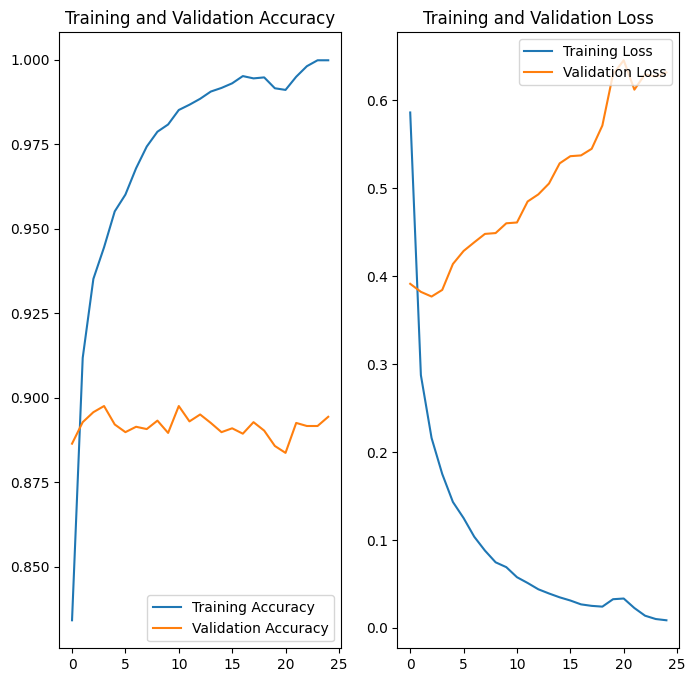

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['n03394916' 'n03417042' 'n02089973' 'n02086240' 'n02105641' 'n02087394'
 'n02099601' 'n02115641' 'n03445777' 'n02102040' 'n03425413' 'n03888257'
 'n03028079' 'n03000684' 'n01440764' 'n02093754' 'n02111889' 'n02096294'
 'n02088364' 'n02979186']


In [ ]:
image_batch, label_batch = next(iter(train_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

1/1 [==============================] - 1s 541ms/step
['n03445777' 'n03888257' 'n03445777' 'n03445777' 'n03425413' 'n02088364'
 'n03028079' 'n03028079' 'n02979186' 'n03888257' 'n02102040' 'n03417042'
 'n02115641' 'n03028079' 'n01440764' 'n02979186' 'n02102040' 'n03888257'
 'n01440764' 'n02102040' 'n02979186' 'n03425413' 'n03417042' 'n03425413'
 'n03425413' 'n02102040' 'n03417042' 'n03417042' 'n02099601' 'n01440764'
 'n03028079' 'n03028079']


In [ ]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [ 8 11  8  8 10 18 12 12 19 11  9  1  7 12 14 19  9 11 14  9 19 10  1 10
 10  9  1  1  6 14 12 12]
Predicted labels:  [ 8 11  8  8 10 18 12 12 19 11  9  1  7 12 14 19  9 11 14  9 19 10  1 10
 10  9  1  1  6 14 12 12]


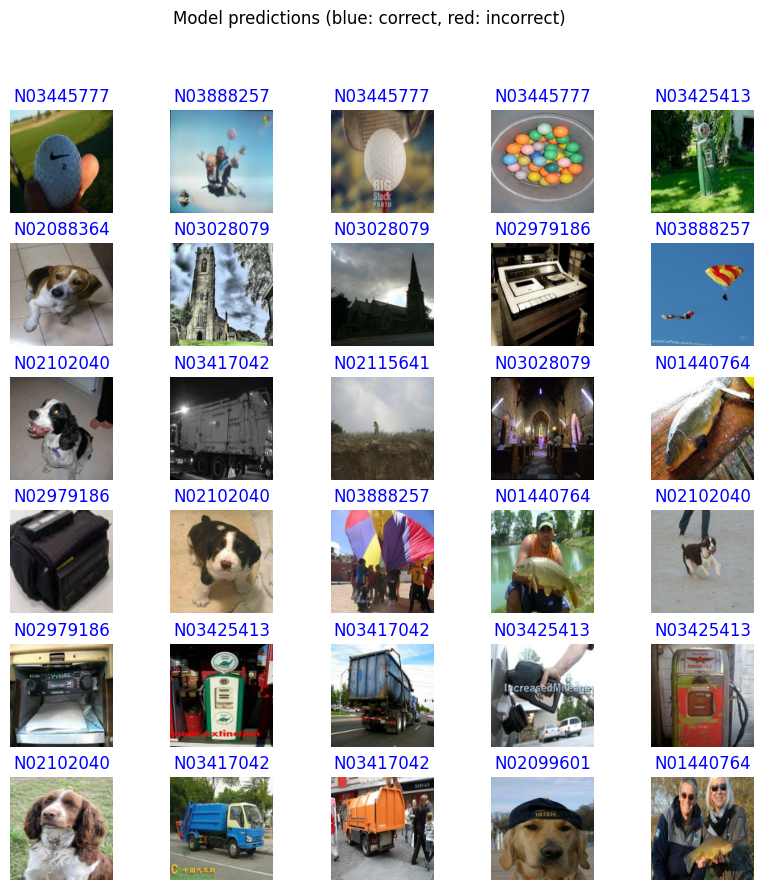

In [ ]:
plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")